<a href="https://colab.research.google.com/github/arashfahim/Corporate-Governance-and-Asset-Pricing/blob/main/Impulse_3D_LOB_Forward_Non_Linear_Coarse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running cost

$\sum_{t=0}^{T-1}D_t\xi_t+\frac{\kappa}{2}\xi^{1+\alpha}_t$

Terminal cost

$D_T(R_0-\sum_{t=0}^{T-1}\xi_t)+\frac{\kappa}{2}(R_0-\sum_{t=0}^{T-1}\xi_t)^{1+\alpha}$

For $T=2$, the total loss is

$D_0\xi_0+\frac{\kappa}{2}\xi^{1+\alpha}_0+D_1(R_0-\xi_0)+\frac{\kappa}{2}(R_0-\xi_0)^{1+\alpha}$

$D_1=\rho(D_0+\kappa \xi_0^{\alpha})$

loss$=D_0\xi_0+\frac{\kappa}{2}\xi^{1+\alpha}_0+\rho(D_0+\kappa \xi_0^{\alpha})(R_0-\xi_0)+\frac{\kappa}{2}(R_0-\xi_0)^{1+\alpha}$

$=D_0\xi_0+\frac{\kappa}{2}\xi^{1+\alpha}_0+\rho D_0R_0-\rho D_0\xi_0+\rho R_0\kappa \xi_0^{\alpha}-\rho \kappa \xi_0^{1+\alpha}+\frac{\kappa}{2}(R_0-\xi_0)^{1+\alpha}$



$=\rho D_0R_0+D_0(1-\rho)\xi_0 + \frac{\kappa}{2}(R_0^2-2(1-\rho)\xi_0(R_0-\xi_0))=\rho D_0R_0+\frac{\kappa}{2}R_0^2+D_0(1-\rho)\xi_0 - {\kappa}(1-\rho)\xi_0(R_0-\xi_0)$

$(1-\rho){\kappa}\xi_0(\frac{D_0}{\kappa} - R_0+\xi_0)$


$\xi_0(\frac{D_0}{\kappa} - R_0+\xi_0)$

------------------------------

Minimization:


$\xi_0^*=\frac{R_0-\frac{D_0}{\kappa}}{2}=\frac{\kappa R_0-{D_0}{}}{2\kappa}$

-------------------------------

If $D_0=0$, $\xi_0=\frac{R_0}{2}$.

Total cost


$D_0\frac{\kappa R_0-D_0}{2\kappa}+\frac{\kappa}{2}\frac{(\kappa R_0-D_0)^2}{4\kappa^2}+D_1(R_0-\frac{\kappa R_0-D_0}{2\kappa})+\frac{\kappa}{2}(R_0-\frac{\kappa R_0-D_0}{2\kappa})^2$


If $D_0=0$, $\frac{\kappa}{4}(1+\rho)R_0^2$


In [ ]:
import numpy as np
import json
from scipy import misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import random
import math
import pandas as pd
import cvxpy as cp
from scipy.optimize import fsolve
import time
import os

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH = r"/content/gdrive/MyDrive/LOB_multi_scale_models/"

# New implementation for GPU

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
param_dict = {
        'M' : 100,# number of samples
        'T' : 10.0, # terminal time
        'iter' : 20, #number of steps minus terminal
        'kappa' : 1e-3, #price impact sensitivity factor
        'rho' : 1e-2, #resillience<1
        'alpha' : 1.0, #price impact exponent
        'X0' : 10000
}

In [ ]:
class opt_exe(nn.Module):#multi_step, optimal_control
    def __init__(self,params):
        super(opt_exe, self).__init__()
        self.layer = torch.nn.Sequential()
        self.layer.add_module("L1",torch.nn.Linear(3, 100))#1d
        self.layer.add_module("Tanh", torch.nn.Tanh())
        self.layer.add_module("L2",torch.nn.Linear(100,120))
        self.layer.add_module("Tanh", torch.nn.Tanh())
        self.layer.add_module("L3",torch.nn.Linear(120,100))
        self.layer.add_module("Tanh", torch.nn.Tanh())
        self.layer.add_module("L4",torch.nn.Linear(100,1))
        self.M = params['M']# number of samples
        self.T= params['T'] # terminal time
        self.iter = params['iter'] #number of steps minus terminal
        self.Dt= torch.Tensor([self.T/self.iter]).to(device) #time step
        self.kappa=torch.Tensor([params['kappa']]).to(device) #price impact sensitivity factor
        self.rho=torch.exp(-params['rho']*self.Dt).to(device) #resillience<1
        self.alpha= params['alpha'] #price impact exponent
        self.X0=params['X0']
        self.D = torch.zeros([self.M,1]).to(device)
        self.R=torch.linspace(self.X0*0.85,self.X0*1.15,self.M).unsqueeze(-1).to(device)#torch.FloatTensor(self.M,1).uniform_(self.X0*0.95,self.X0*1.05).to(device)
        self.tx = torch.cat(((torch.Tensor([0.0]).repeat([self.M,1])).to(device),self.D,self.R),axis=1)
        self.opt_path = torch.zeros([self.M,self.iter+1,3]).to(device)
        self.opt_exe = torch.zeros([self.M,self.iter+1]).to(device)

    def forward(self, tx):
        val = self.layer(tx)
        return val#torch.Tensor([0.5]).to(device)*tx[:,-1]#val

    def unit(self,tx):
        exe_ = self.forward(tx)# \xi(t,X_t) optimal strategy
        co_ = (tx[:,1]*exe_.squeeze(-1)+torch.Tensor([1/(1+self.alpha)]).to(device)*self.kappa *torch.pow(torch.abs(exe_.squeeze(-1)),1+self.alpha))#*self.Dt impulse control does not have Delta t
        up_ = torch.cat((tx[:,0].unsqueeze(-1)+self.Dt, self.rho*(tx[:,1].unsqueeze(-1)+self.Dt*self.kappa*torch.sign(exe_)*torch.pow(torch.abs(exe_),self.alpha)), tx[:,2].unsqueeze(-1)-exe_),axis=1)
        return exe_, co_, up_

    def loss(self):
        for i in range(self.iter):
            if i == 0:
                #X_0=(0,0,R_0)
                tx = self.tx
                # self.tx[:,i,:] = tx
                exe_, co_, up_ = self.unit(tx) # \xi(0,X_0), running cost for X_0, X_{t_1}
                # print("exe:",exe_,"cost:",co_,"update:",up_)
                cost = co_ #record running cost
                # sum = exe_ # record executed order
                # print("price impact:", up_[:,1])
                # print("exe ",exe_)
            else:
                # self.tx[:,i,:] = up_
                exe_, co_, up_ = self.unit(up_) # \xi(t_i,X_{t_i}), running cost for X_{t_i}, X_{t_{i+1}}
                cost = cost + co_ # add the running cost
                # sum = sum + exe_  # add the executed order to total
        # last step
        # print(up_)
        # self.tx[:,self.iter,:] = up_
        # print(self.R)
        # remain = self.R - sum # remaining balance carried to the last order
        # print(remain,up_[:,-1])
        cost = cost + self.Dt*(up_[:,1]*up_[:,-1]+torch.Tensor([1/(1+self.alpha)]).to(device)*self.kappa *torch.pow(torch.abs(up_[:,-1]),1+self.alpha)).squeeze(-1)   # cost of last order
        return torch.mean(cost)

    def approx_loss_2(self):
        for i in range(self.iter):
            if i == 0:
                self.opt_path[:,i,:] = self.tx.squeeze(-1)
                exe_, co_, up_ = self.unit(self.tx) # \xi(0,X_0), running cost for X_0, X_{t_1}
                cost = co_ #record running cost
                # sum = exe_ # record executed order
                # print(exe_)
                self.opt_exe[:,i] = exe_.squeeze(-1)
            else:
                self.opt_path[:,i,:] = up_
                exe_, co_, up_ = self.unit(up_) # \xi(t_i,X_{t_i}), running cost for X_{t_i}, X_{t_{i+1}}
                cost = cost + co_ # add the running cost
                # sum = sum + exe_  # add the executed order to total
                # print(exe_)
                self.opt_exe[:,i] = exe_.squeeze(-1)
        # last step
        self.opt_path[:,self.iter,:] = up_
        # print(exe_)
        remain = up_[:,-1] # remaining balance carried to the last order
        self.opt_exe[:,self.iter] = remain
        cost = cost + self.Dt*(up_[:,1]*remain+torch.Tensor([1/(1+self.alpha)]).to(device)*self.kappa *torch.pow(torch.abs(remain),1+self.alpha))   # cost of last order
        return torch.mean(cost)#torch.cat((tx[:,-1].unsqueeze(-1),cost.unsqueeze(-1)),axis=1)


    def optimal_path(self,tx):
        M = tx.shape[0]
        opt_path = torch.zeros([M,self.iter+1,3]).to(device)
        opt_exe = torch.zeros([M,self.iter+1]).to(device)
        for i in range(self.iter):
            if i == 0:
                opt_path[:,i,:] = tx.squeeze(-1)
                exe_, co_, up_ = self.unit(tx) # \xi(0,X_0), running cost for X_0, X_{t_1}
                cost = co_ #record running cost
                # sum = exe_ # record executed order
                # print(exe_)
                # print(i,":",exe_,",",up_[:,-1])
                opt_exe[:,i] = exe_.squeeze(-1)
            else:
                opt_path[:,i,:] = up_
                exe_, co_, up_ = self.unit(up_) # \xi(t_i,X_{t_i}), running cost for X_{t_i}, X_{t_{i+1}}
                cost = cost + co_ # add the running cost
                # sum = sum + exe_  # add the executed order to total
                # print(i,":",exe_,",",up_[:,-1])
                opt_exe[:,i] = exe_.squeeze(-1)
        # last step
        opt_path[:,self.iter,:] = up_
        # print(exe_)
        remain = up_[:,-1] # remaining balance carried to the last order
        # print("last: ",remain)
        opt_exe[:,self.iter] = remain
        cost = cost + self.Dt*(up_[:,1]*remain+torch.Tensor([1/(1+self.alpha)]).to(device)*self.kappa *torch.pow(torch.abs(remain),1+self.alpha))   # cost of last order
        return opt_path, opt_exe, cost#torch.cat((tx[:,-1].unsqueeze(-1),cost.unsqueeze(-1)),axis=1)

    def visualize(self):
        self.approx_loss_2()
        self.eval_closed_form()
        ind = range(30,self.M-30,20)
        h = []
        l = []
        color = cm.rainbow(np.linspace(0, 1, len(ind)))
        fig, ax = plt.subplots(len(ind),1,figsize=(len(ind)*2.5,5),dpi=300)
        for i in range(len(ind)):
            ax[i].bar(self.opt_path[ind[i],:,0].cpu().detach().numpy(),self.opt_exe[ind[i],:].clone().detach().cpu().numpy(),label=r"$R_0$="+str(self.R[ind[i],0].detach().cpu().numpy()),color=color[i],width=0.5*p1.Dt.cpu().numpy())
            h_, l_ = ax[i].get_legend_handles_labels()
            h = h + h_
            l = l + l_

        ax[0].legend(h,l,loc='best',bbox_to_anchor=(1.0, 0.1, 0.2, 0.5));#, );
        plt.tight_layout();

    def eval_closed_form(self):
        self.closed_form = dict()
        # output = dict()
        for index, X0 in enumerate(self.R):
            cls0 = [X0/(2+(self.iter-1)*(1-self.rho))]
            cls = [(1-self.rho)*cls0[0]]*(self.iter-1)
            cls_ = cls0
            cls = cls0+cls+cls_
            vt = torch.Tensor(cls)
            v = vt.detach().cpu().numpy()
            tau = self.rho.detach().cpu().numpy()
            Q = np.fromfunction(lambda i, j: np.power(tau,np.abs(i-j)), (self.iter+1, self.iter+1), dtype=float)
            cost = torch.from_numpy(0.5*np.matmul(np.matmul(v,Q),v.reshape(self.iter+1,1))).to(device)*self.kappa#*self.Dt impulse control does not have Delta t
            # x = X0[0].detach().cpu().numpy()
            # print(x)
            # output[X0] = [vt,cost]
            self.closed_form[index] = [X0,vt,cost]


In [ ]:
p1 = opt_exe(param_dict).to(device)

**path to save the outcome**

In [ ]:
od = p1.state_dict()
arch = '3D'
for key, value in od.items():
    if 'bias' in key:
        arch = "-".join([arch,str(value.shape[0])])
nom = ''
for k,v in param_dict.items():
    nom = nom + '_' + k + '_' + str(v)
path = PATH + arch + nom
if not os.path.exists(path):
    os.mkdir(path)
with open(path+"/params.json", "w") as outfile:
    json_object = json.dumps(param_dict, indent=4)
    outfile.write(json_object)

In [ ]:
p1.tx[10,:].unsqueeze(0)

tensor([[   0.0000,    0.0000, 8803.0303]], device='cuda:0')

In [ ]:
# p1(p1.tx)

In [ ]:
p1.optimal_path(p1.tx)[0].shape,p1.optimal_path(p1.tx)[1].shape

(torch.Size([100, 21, 3]), torch.Size([100, 21]))

In [ ]:
p1.approx_loss_2()

tensor(25199.3340, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
p1.loss()

tensor(25199.3340, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
lr1 = 1e-3
# lr2 = 1e-2
num_epochs = 1000
optimizer1 = optim.Adam(p1.parameters(), lr1)#,weight_decay=1e-2
# scheduler1 = lr_scheduler.LinearLR(optimizer1, start_factor=lr1, end_factor=lr2, total_iters=100)
L_ = torch.Tensor([-2000.0]).to(device)
cost = p1.loss()
loss_epoch = dict()
start=time.time()
duration = 0
epoch = 0
err = 1e-10

In [ ]:
while (torch.abs(L_-cost)/torch.abs(L_)>err) &  (epoch <= num_epochs):#
    optimizer1.zero_grad()
    cost=p1.loss()
    cost.backward()
    optimizer1.step()
    #   before_lr = optimizer1.param_groups[0]["lr"]
    #   scheduler1.step()
    #   after_lr = optimizer1.param_groups[0]["lr"]
    loss_epoch[epoch] = cost
    if epoch>0:
        L_ = loss_epoch[epoch-1]
    if (epoch % 100==0):
        print("At epoch {} the cost is {}.".format(epoch,cost.detach()))
        # print("Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr))
        # print("We are currently at cost {} versus analytic {}".format(p1.approx_loss_2(torch.Tensor([[0.0, 0.0, 10.0]]).to(device)),p1.analytic_loss_2(torch.Tensor([[10.0]]).to(device))))
    if  (torch.abs(L_-cost)/torch.abs(L_)<=err):
        print("Delta Loss = {} , epoch = {}".format(torch.abs(L_-cost)/torch.abs(L_),epoch))
        print("Final cost tally {}".format(p1.approx_loss_2(),cost))#,p1.analytic_loss_2(torch.Tensor([[10.0]]).to(device))
    epoch += 1
end= time.time()
duration += end-start
print("Learning time: {}".format(duration))

At epoch 0 the cost is 25199.333984375.
At epoch 100 the cost is 12845.6767578125.
At epoch 200 the cost is 12829.66015625.
Delta Loss = 0.0 , epoch = 233
Final cost tally 12820.9599609375
Learning time: 16.593934297561646


In [ ]:
loss_epoch_=dict()
for k,v in loss_epoch.items():
    loss_epoch_[k] = float(v.cpu().detach().numpy())

In [ ]:
with open(path+"/progress_ckeckpoint.json", "w") as outfile:
    json_object = json.dumps(loss_epoch_, indent=4)
    outfile.write(json_object)

In [ ]:
# pd.DataFrame(optimizer1.state_dict()).to_csv(path+"/optimal_path.csv", index=False)
# optimizer1.state_dict()

In [ ]:
p1.approx_loss_2()

tensor(12820.9600, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
p1.opt_path[50,:,-1]

tensor([10015.1514,  9520.7061,  9026.2607,  8531.8154,  8037.3701,  7542.9248,
         7048.4795,  6554.0342,  6059.5889,  5565.1436,  5070.6982,  4576.2529,
         4081.8079,  3587.3628,  3092.9185,  2598.4814,  2104.1270,  1610.8313,
         1135.0348,   765.5770,   445.6503], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [ ]:
p1.opt_exe[10,:]

tensor([ 494.4451,  494.4451,  494.4451,  494.4451,  494.4451,  494.4451,
         494.4451,  494.4451,  494.4451,  494.4451,  494.4450,  494.4441,
         494.4346,  494.3241,  492.8701,  467.6905,  355.6180,  311.6470,
         294.6027, -252.0805,  210.5818], device='cuda:0',
       grad_fn=<SliceBackward0>)

# **Saving the model**

In [ ]:
torch.save(p1.state_dict(),path+"/model.pt")

In [ ]:
# pd.DataFrame(p1.opt_path.cpu().detach().numpy()).to_csv(path+"/optimal_path.csv", index=False)
pd.DataFrame(p1.opt_exe.cpu().detach().numpy()).to_csv(path+"/optimal_exe.csv", index=False)

# Visualization

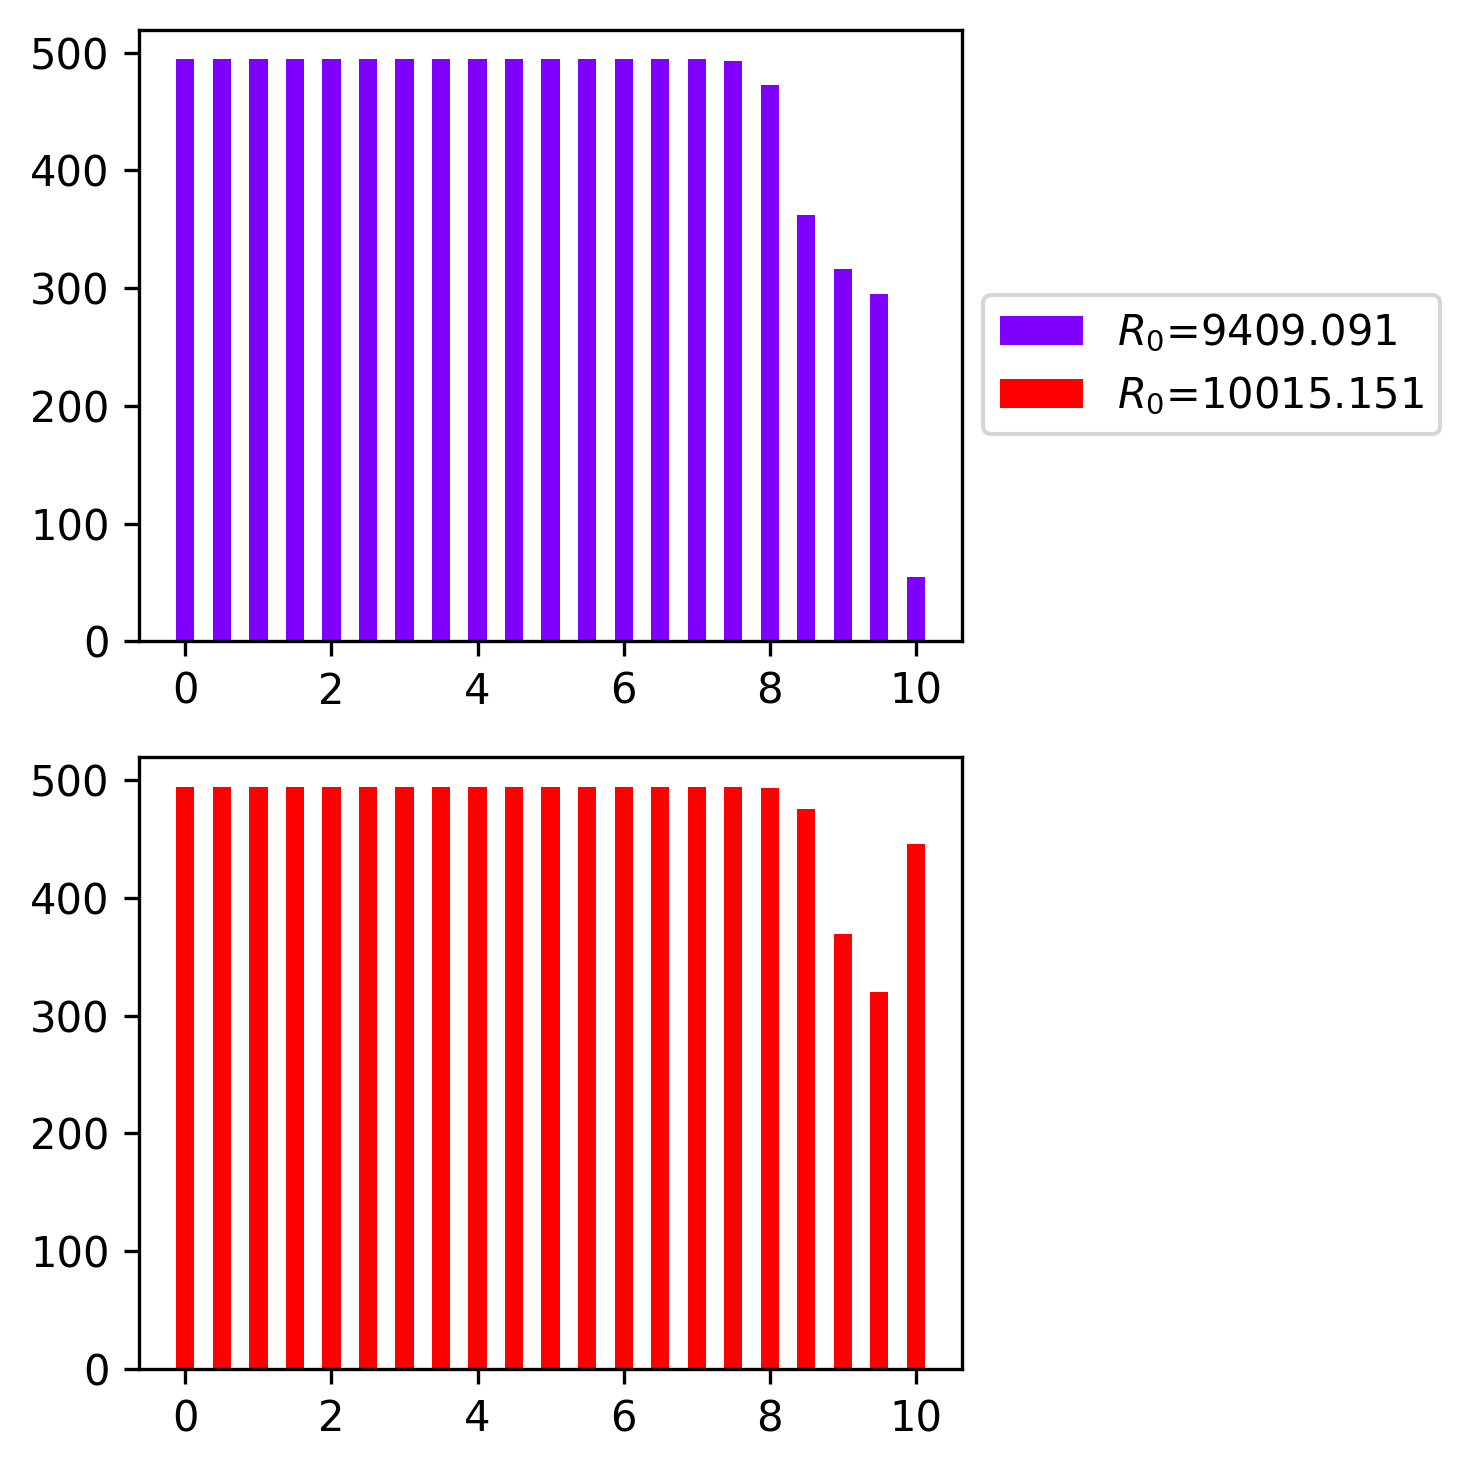

In [ ]:
p1.visualize()
plt.savefig(path+"/plots.svg")



In [ ]:
p1.closed_form[50]

[tensor([10015.1514], device='cuda:0'),
 tensor([4781.0449,   23.8454,   23.8454,   23.8454,   23.8454,   23.8454,
           23.8454,   23.8454,   23.8454,   23.8454,   23.8454,   23.8454,
           23.8454,   23.8454,   23.8454,   23.8454,   23.8454,   23.8454,
           23.8454,   23.8454, 4781.0449]),
 tensor([23881.7424], device='cuda:0', dtype=torch.float64)]

In [ ]:
p1.optimal_path(p1.tx[50,:].unsqueeze(0))

(tensor([[[0.0000e+00, 0.0000e+00, 1.0015e+04],
          [5.0000e-01, 2.4599e-01, 9.5207e+03],
          [1.0000e+00, 4.9075e-01, 9.0263e+03],
          [1.5000e+00, 7.3429e-01, 8.5318e+03],
          [2.0000e+00, 9.7662e-01, 8.0374e+03],
          [2.5000e+00, 1.2177e+00, 7.5429e+03],
          [3.0000e+00, 1.4577e+00, 7.0485e+03],
          [3.5000e+00, 1.6964e+00, 6.5540e+03],
          [4.0000e+00, 1.9339e+00, 6.0596e+03],
          [4.5000e+00, 2.1702e+00, 5.5651e+03],
          [5.0000e+00, 2.4054e+00, 5.0707e+03],
          [5.5000e+00, 2.6394e+00, 4.5763e+03],
          [6.0000e+00, 2.8722e+00, 4.0818e+03],
          [6.5000e+00, 3.1039e+00, 3.5874e+03],
          [7.0000e+00, 3.3344e+00, 3.0929e+03],
          [7.5000e+00, 3.5638e+00, 2.5985e+03],
          [8.0000e+00, 3.7919e+00, 2.1041e+03],
          [8.5000e+00, 4.0184e+00, 1.6108e+03],
          [9.0000e+00, 4.2351e+00, 1.1350e+03],
          [9.5000e+00, 4.3978e+00, 7.6558e+02],
          [1.0000e+01, 4.5350e+00, 4.456

In [ ]:
p1.tx[49,:]

tensor([   0.0000,    0.0000, 9984.8486], device='cuda:0')

In [ ]:
p1.optimal_path(p1.tx[50,:].unsqueeze(0))[1].sum()

tensor(10015.1523, device='cuda:0', grad_fn=<SumBackward0>)

In [ ]:
k = 50
print("The percentage of relative error is {}%.".format((torch.abs(p1.optimal_path(p1.tx[k,:].unsqueeze(0))[-1]-p1.closed_form[k][-1])/p1.closed_form[k][-1]*100).detach().cpu().numpy()[0]))

The percentage of relative error is 46.72637074054113%.
